# Neural System Identification

This notebook accompanies our submitted paper "Neural Nonlinear State-Space Identification".

## 1. Introduction

## 2. Background

The nonlinear system identification problem is to find an autoregressive model $f$ where the current output depends on delayed outputs $y$ and control inputs $u$,
%
\begin{equation}
    y(t) = f(y(t-1),y(t-2),\ldots,y(t-L),u(t-1),u(t-2),\ldots,u(t-L)) + \epsilon \enspace ,
\end{equation}
%
where $\epsilon$ is white noise, $t$ is the sample index (time instant), and $L$ is the number of past samples. The model function $f(\cdot)$ is generally unknown, but can be approximated by a neural network $f_\theta$ parametrized with $\theta$ which are optimized using training samples.

## 3. Related work

## 4. Methods

The illustrative environment is the Gymnasium environment *Pendulum* 

<div><img src="images/pendulum.png"/></div>

which observation space $\mathbf{y]$ is (x and y denote also the cartesian coordinates):

 * $y_0 = x = \cos\theta$
 * $y_1 = y = \sin\theta$
 * $y_2 = \dot\theta$

and the action space is

 * $u \in [-2,+2]$

The initial state is

 * $\theta \in [ -180,+180 ]$
 * $\dot\theta \in [ -1,+1 ]$   

The full description is available at the Gymnasium::[pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/).

Install Gymnasium and then create the Pendulum environment

In [1]:
import gymnasium as gym
import numpy as np
env = gym.make('Pendulum-v1', g=9.81)

### Example: Run the environment and plot the state variables

Let's run the system starting from a random starting angle $\theta_0$ and without control, i.e. $u(t) = 0~\forall~t$ and see how it behaves.
\begin{equation}
 y(t) = f(y(t-1),y(t-2),\ldots,y(t-L)) \enspace .
\end{equation}

In [4]:
epi_max_len = 1000

observation, info = env.reset()
print(f'Initial x={observation[0]}, y={observation[1]}, and velocity {observation[2]}')

y_0 = observation
u_vec = np.empty((epi_max_len,1))
y_vec = np.empty((epi_max_len,3))

for t in range(epi_max_len):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    action = [0]
    observation, reward, terminated, truncated, info = env.step(action)
    u_vec[t] = action
    y_vec[t,:] = observation
    
    if terminated or truncated:
        break;
print(f'Starting point is theta={y_0} and the final time instant t is {t}')

Initial x=0.9834871888160706, y=-0.18097785115242004, and velocity -0.29446059465408325
Starting point is theta=[ 0.9834872  -0.18097785 -0.2944606 ] and the final time instant t is 199


Plot the state variables (note that starting point is random so the plot is also different)

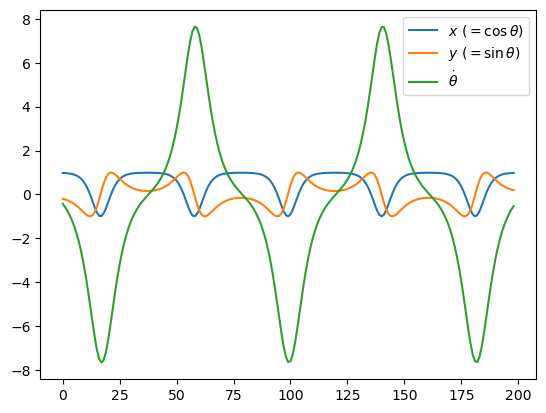

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(t), y_vec[:t,:],label=[r'$x~(=\cos\theta)$', r'$y~(=\sin\theta)$', r'$\dot\theta$'])
plt.legend()
plt.show()

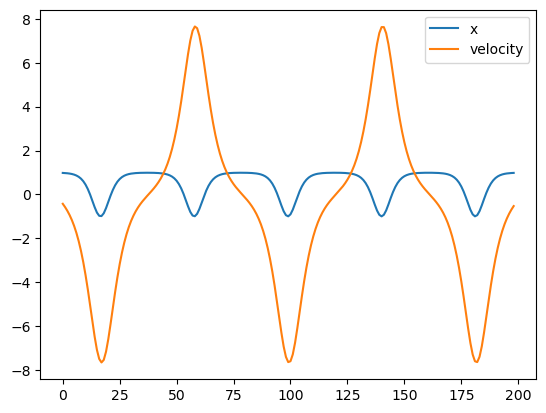

In [7]:
#plt.plot(range(t), np.arctan(y_vec[:t,1]/y_vec[:t,0]))
plt.plot(range(t), y_vec[:t,0])
plt.plot(range(t), y_vec[:t,2])
plt.legend(['x','velocity'])
plt.show()

**Findings:** The plot of $\dot\theta$ is always sinusoidal as it should be. However, $x$ and $y$ less so because of the mapping of $\theta$ by the sin (odd) and cos (even) functions. However, by limiting analysis to pendulum that swings always downwards (the vertical coordinate x always negative) this does not bother us.

**Note:** Gymnasium does not provide easy ways to initialize the environments so we must reset the environment until it provides a starting point where x coordinate is negative. We might also restrict the initial velocity below some maximum magnitude.

In [12]:
observation, info = env.reset()
while observation[0] > 0 or abs(observation[2]) > 0.1:
    observation, info = env.reset()

print(f'Initial x={observation[0]}, y={observation[1]}, and velocity {observation[2]}')

Initial x=-0.9989019632339478, y=0.04684892296791077, and velocity -0.015574350021779537


Define a function that can be easily called when we collect training and test data.

In [13]:
def my_env_reset(env_):
    observation, info = env_.reset()
    while observation[0] > 0 or abs(observation[2]) > 0.1:
        observation, info = env_.reset()
    return observation,info

### 4.1 Multilayer perceptron (MLP)

Let's train an MLP neural network using the current state variables at time instant $t-1$
$$
\vec{x}_{t-1} = (\cos\theta_{t-1}, \sin\theta_{t-1}, \dot\theta_{t-1})^T
$$
as input, and their new predicted values as output
$$
\vec{y}_t = f(\vec{x}_{t-1}) = \hat{\vec{x}}_t  \enspace ,
$$
where $\hat{\vec{x}}_t$ denotes an estimate of the true value $\vec{x}_t$.

Collect a training dataset of $N_{tr}$ samples. If the environment is terminated, it is restarted until enough samples in the training buffer. Let's utilize the following heuristic training steps:

 * Find a network structure and number of epochs so that the network completely learns 10 episodes (can overfit to data)
 * Search which error level should be achieved until training fit is good, and then add neurons and training data to achieve the same with validation data
 * Increase number of samples until it does not anymore overfit
 * Optimize everything for the validation data

In [70]:
num_of_tr_samples = 1000

X_tr = np.empty((num_of_tr_samples,3))
Y_tr = np.empty((num_of_tr_samples,3))

epi_max_len = 101
epi_tot = 1
epi_step = 0
observation, info = my_env_reset(env)

y_0 = observation

for n in range(num_of_tr_samples):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    action = [0]
    observation_new, reward, terminated, truncated, info = env.step(action)
    X_tr[n,:] = observation
    Y_tr[n,:] = observation_new
    
    if terminated or truncated or epi_step == epi_max_len-1:
        observation, info = my_env_reset(env)
        epi_tot += 1
        epi_step = 0
    else:
        epi_step += 1
    observation = observation_new


print(f'Starting point is theta={y_0} and training data contains data from {epi_tot} episodes')

Starting point is theta=[-0.5051662  -0.8630221   0.07117727] and training data contains data from 10 episodes


#### Example: Training MLP for a fully observable environment

In [86]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(3)
])

loss_fn = tf.keras.losses.MeanAbsoluteError()

model.compile(optimizer='adam',
              loss=loss_fn)

TensorFlow version: 2.12.0


Train the model for some epochs

In [92]:
history = model.fit(X_tr,Y_tr, epochs=500, batch_size=num_of_tr_samples)

Epoch 1/500
1/1 [==============================] - 0s 9ms/step - loss: 0.2866
Epoch 2/500
1/1 [==============================] - 0s 9ms/step - loss: 0.2860
Epoch 3/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2854
Epoch 4/500
1/1 [==============================] - 0s 6ms/step - loss: 0.2848
Epoch 5/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2841
Epoch 6/500
1/1 [==============================] - 0s 6ms/step - loss: 0.2835
Epoch 7/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2829
Epoch 8/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2822
Epoch 9/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2816
Epoch 10/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2810
Epoch 11/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2803
Epoch 12/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2797
Epoch 13/500
1/1 [==============================] - 0s 7ms/st

Plot the loss to make sure model is learning

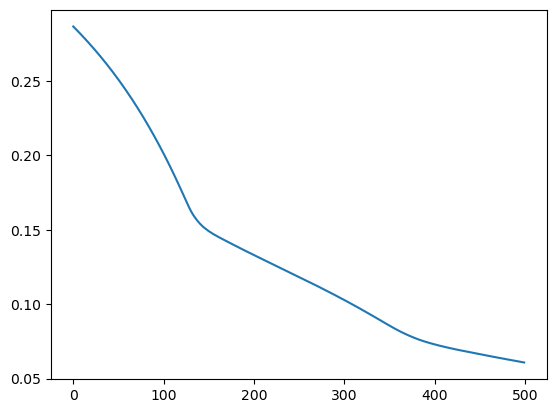

In [93]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

4/4 [==============================] - 0s 3ms/step


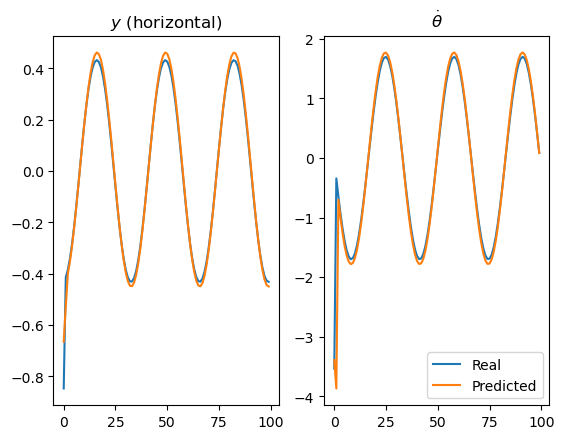

In [95]:
start_ind = np.random.randint(0,num_of_tr_samples-100)
#start_ind = 0
Y_tr_hat = model.predict(X_tr[start_ind:start_ind+100])

plt.subplot(1,2,1)
plt.title(r'$y$ (horizontal)')
plt.plot(range(100), Y_tr[start_ind:start_ind+100,1], range(100), Y_tr_hat[:,1])
plt.subplot(1,2,2)
plt.plot(range(100), Y_tr[start_ind:start_ind+100,2], range(100), Y_tr_hat[:,2])
plt.title(r'$\dot\theta$')
plt.legend(['Real', 'Predicted'])
plt.show()

Run one episode and store N_te samples for testing

In [96]:
num_of_te_samples = 100

X_te = np.empty((num_of_te_samples,3))
Y_te = np.empty((num_of_te_samples,3))

epi_tot = 1
observation, info = my_env_reset(env)

y_0 = observation

for n in range(num_of_te_samples):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    action = [0]
    observation_new, reward, terminated, truncated, info = env.step(action)
    X_te[n,:] = observation
    Y_te[n,:] = observation_new
    
    if terminated or truncated:
        observation, info = env.reset()
        epi_tot += 1
    observation = observation_new

print(f'Starting point is theta={y_0} and training data contains data from {epi_tot} episodes')

Starting point is theta=[-0.4274872  -0.9040214   0.04763547] and training data contains data from 1 episodes


Compute predictions

In [97]:
Y_hat = model.predict(X_te)

4/4 [==============================] - 0s 3ms/step


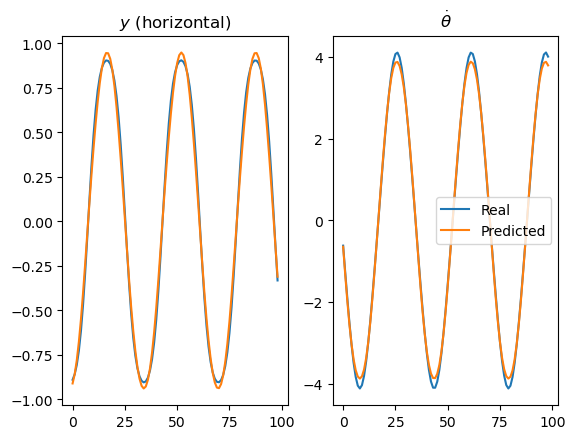

In [98]:
plt.subplot(1,2,1)
plt.title(r'$y$ (horizontal)')
plt.plot(range(n), Y_te[:n,1], range(n), Y_hat[:n,1])
plt.subplot(1,2,2)
plt.plot(range(n), Y_te[:n,2], range(n), Y_hat[:n,2])
plt.title(r'$\dot\theta$')
plt.legend(['Real', 'Predicted'])
plt.show()

In [99]:
Y_hat = np.empty((num_of_te_samples,3))

Y_hat[0,:] = model.predict(np.reshape(X_te[0,:],[1,3]))

for te_ind in range(1,num_of_te_samples):
    Y_hat[te_ind,:] = model.predict(np.reshape(Y_hat[te_ind-1,:],[1,3]))    

1/1 [==============================] - 0s 26ms/step


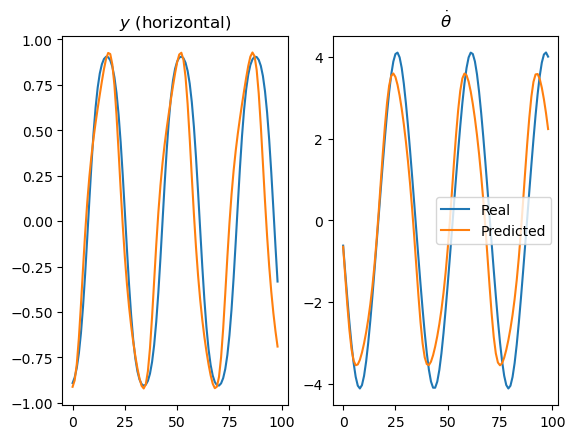

In [100]:
plt.subplot(1,2,1)
plt.title(r'$y$ (horizontal)')
plt.plot(range(n), Y_te[:n,1], range(n), Y_hat[:n,1])
plt.subplot(1,2,2)
plt.plot(range(n), Y_te[:n,2], range(n), Y_hat[:n,2])
plt.title(r'$\dot\theta$')
plt.legend(['Real', 'Predicted'])
plt.show()

The results show that nothing works. The estimated pose cannot be correct since

 * Not even the first estimate cannot be correct as the environment always restarts from random pose
 * All history of actions is lost

**Findings:** A rather small MLP (3-8-8-3) learns to map and predict the future states well.

#### Example: Training MLP for a partially observable data

Knowing the current location of pendulum head ($x_t,y_t$) does not provide sufficient information to predict the next stage without knowing its velocity $\dot\theta$. This makes the environment only *partially observable*. Let's see how well a vanilla MLP can now perform.

#### Example: Training MLP with N previous samples as inputs

Partially observable information can be made more observable by adding N past examples.

#### Example: Training MLP with N previous samples and control as inputs

So far we have omitted the control $\vec{u}_t$ but let's see what happens when it is added.

Construct training data of relative poses

In [ ]:
N_tr = 1000

observation, info = env.reset()

p_0 = observation
a_l = np.empty((N_tr,1))
p_l = np.empty((N_tr,3))
p_delta_l = np.empty((N_tr,3))

prev_observation = observation
num_of_e = 1
for s in range(N_tr):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    action = [0]
    observation, reward, terminated, truncated, info = env.step(action)
    a_l[s] = action
    p_l[s,:] = observation
    p_delta_l[s,:] = observation-prev_observation
    
    if terminated or truncated:
        observation, info = env.reset()
        num_of_e += 1
    prev_observation = observation
print(f'Contains data from {num_of_e} episodes')

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(3)
])

loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer='adam',
              loss=loss_fn)

In [ ]:
history = model.fit(a_l,p_delta_l, epochs=5)

In [ ]:
plt.plot(history.history['loss'])

Run episode for testing

In [ ]:
N_te = 100

observation, info = env.reset()

p_0_test = observation 
a_l_test = np.empty((N_te,1))
p_l_test = np.empty((N_te,3))

for s in range(N_te):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    a_l_test[s] = action
    p_l_test[s,:] = observation
    
    if terminated or truncated:
        break

print(f'{s+1} samples generated for testing')
env.close()

Add the starting point and compute cumulative sum of deltas

In [ ]:
p_delta_hat = model.predict(a_l_test)
p_hat = p_0_test+np.cumsum(p_delta_hat, axis=0)

In [ ]:
plt.subplot(1,3,1)
plt.plot(range(s), p_l_test[:s,0], range(s), p_hat[:s,0])
plt.title('x')
plt.legend(['gt','predicted'])
plt.subplot(1,3,2)
plt.title('y')
plt.plot(range(s), p_l_test[:s,1], range(s), p_hat[:s,1])
plt.subplot(1,3,3)
plt.title('Angular velocity')
plt.plot(range(s), p_l_test[:s,2], range(s), p_hat[:s,2])
plt.show()

Results show that the first 1-2 estimates are close to the starting point, but otherwise estimates are wrong. For example, what happens next is very different for a pendulum swinging from left to right than right to left. And the first action has very little effect to that.

### Experiment 3: Fixing the starting point for delta pose estimation

This starts to make sense, since the same actions have always the same effect if we always start from the same pose.

**Note:** Instead of long sequences, let's use only short sequences as actual pose depends on action history and this still does not have idea what the previous actions have been.

In [ ]:
rand_seed = 42
N_tr = 1000
T_max = 5 # This many steps at most in every episode

observation, info = env.reset(seed=rand_seed)

p_0 = observation
a_l = np.empty((N_tr,1))
p_l = np.empty((N_tr,3))
p_delta_l = np.empty((N_tr,3))

prev_observation = observation
num_of_e = 1
for s in range(N_tr):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    action = [0]
    observation, reward, terminated, truncated, info = env.step(action)
    a_l[s] = action
    p_l[s,:] = observation
    p_delta_l[s,:] = observation-prev_observation
    
    if terminated or truncated or (s % T_max) == 0:
        observation, info = env.reset(seed=rand_seed)
        num_of_e += 1
    prev_observation = observation
print(f'Contains data from {num_of_e} episodes')

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(3)
])

loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer='adam',
              loss=loss_fn)

In [ ]:
history = model.fit(a_l,p_delta_l, epochs=5)

In [ ]:
plt.plot(history.history['loss'])

Generate training data

**Note:** You must generate several times as sometimes the result is good and sometimes not (note the randomness in action selection)

In [ ]:
N_te = 50

observation, info = env.reset(seed=rand_seed)

p_0_test = observation 
a_l_test = np.empty((N_te,1))
p_l_test = np.empty((N_te,3))

for s in range(N_te):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    a_l_test[s] = action
    p_l_test[s,:] = observation
    
    if terminated or truncated:
        break

print(f'{s+1} samples generated for testing')
env.close()

In [ ]:
p_delta_hat = model.predict(a_l_test)
p_hat = p_0_test+np.cumsum(p_delta_hat, axis=0)

In [ ]:
plt.subplot(1,3,1)
plt.plot(range(s), p_l_test[:s,0], range(s), p_hat[:s,0])
plt.title('x')
plt.legend(['gt','predicted'])
plt.subplot(1,3,2)
plt.title('y')
plt.plot(range(s), p_l_test[:s,1], range(s), p_hat[:s,1])
plt.subplot(1,3,3)
plt.title('Angular velocity')
plt.plot(range(s), p_l_test[:s,2], range(s), p_hat[:s,2])
plt.show()

Now the estimates start to look more meaningful. Since the pose always starts from the same initial pose, the first estimates are close to correct. However, the quality degrades the longer time from the beginning. This is because the estimate does not have an idea how many time steps have been taken (the longer time the more random actions). Therefore it is also difficult to make this predictor work well if the sequence lenght substantially increases.

**Note:** This would improve the more history inputs added, BUT that only moves drifting away further, not solve it.

### Experiment 4: Giving the predictor sense of time

The accumulation of time should aid the predictor to estimate what has happened so far and thus be much better in predicting how the current action will change the pose. Note that this cannot be accurate as actions have been random so that also affects to the current pose and also what happens next.

In [ ]:
rand_seed = 42
N_tr = 2000
T_max = 20 # This many steps at most in every episode

observation, info = env.reset(seed=rand_seed)

p_0 = observation
a_l = np.empty((N_tr,1))
p_l = np.empty((N_tr,3))
p_delta_l = np.empty((N_tr,3))
t_l = np.empty((N_tr,1))

prev_observation = observation
num_of_e = 1
steps = 0
for s in range(N_tr):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    action = [0]
    observation, reward, terminated, truncated, info = env.step(action)
    a_l[s] = action
    p_l[s,:] = observation
    p_delta_l[s,:] = observation-prev_observation
    t_l[s] = steps
    
    if terminated or truncated or (s % T_max) == 0:
        observation, info = env.reset(seed=rand_seed)
        num_of_e += 1
        steps = 0
    else:
        steps += 1
        
    prev_observation = observation
print(f'Contains data from {num_of_e} episodes')

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(3)
])

loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer='adam',
              loss=loss_fn)

In [ ]:
X = np.hstack([a_l,t_l])

history = model.fit(X,p_delta_l, epochs=10)

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
N_te = 50

observation, info = env.reset(seed=rand_seed)

p_0_test = observation 
a_l_test = np.empty((N_te,1))
p_l_test = np.empty((N_te,3))
t_l_test = np.empty((N_te,1))

steps = 0
for s in range(N_te):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    a_l_test[s] = action
    p_l_test[s,:] = observation
    t_l_test[s] = steps

    steps += 1
    if terminated or truncated:
        break

print(f'{s+1} samples generated for testing')
env.close()

In [ ]:
X_te = np.hstack([a_l_test,t_l_test])

p_delta_hat = model.predict(X_te)
p_hat = p_0_test+np.cumsum(p_delta_hat, axis=0)

In [ ]:
plt.subplot(1,3,1)
plt.plot(range(s), p_l_test[:s,0], range(s), p_hat[:s,0])
plt.title('x')
plt.legend(['gt','predicted'])
plt.subplot(1,3,2)
plt.title('y')
plt.plot(range(s), p_l_test[:s,1], range(s), p_hat[:s,1])
plt.subplot(1,3,3)
plt.title('Angular velocity')
plt.plot(range(s), p_l_test[:s,2], range(s), p_hat[:s,2])
plt.show()

## Summary

There are reasons to suspect that what Cioffi et al. propose in their article does not actually work very well. At least, it does not work in general as illustrated using the pendulum example in this notebook. There are several take home messages:

 * The relative angular pose change $\Delta p_t$ at time t and caused by some action $a_t$ depends on the pose $p_{t-1}$ at the moment t-1.
 * Estimation of the absolute pose $p_t$ requires the full history of actions $a_0, a_1, \ldots, a_t$.
 * Processing of an arbitrary sequence requires usage of recurrent neural networks (RNNs)
 * RNNs can be difficult to train for long sequences
 * Alternatively we can have an MLP that inputs the previous pose estimate $\hat{p}_{t-1}$ AND T previous actions $a_0, a_1,\ldots , a_{T-1}$ and outputs the new estimate $\hat{p}_t$. In the next step the inputs are $\hat{p}_t$ and $a_1, a_2,\ldots , a_T$. 